In [658]:
print('hehe')

hehe


USER DEFINED VARIABLES

In [659]:
low_bound = -100
up_bound = 100
no_of_clusters =2
solution_dimension = 4
total_budget = 3e5
alpha = 0.6
no_of_neighbours = 40
step_size_param = 10 # never changes
step_size = step_size_param

In [660]:
import heapq
import numpy as np
import math
def stochastic_cost_function_helper(x:list[int]): #here x holds [x1,x2,x3,.....]
    x = np.array(x)
    
    # Extract individual elements
    x1, x2, x3, x4 = x
    
    # Compute the deterministic part of the expression
    result = (x1 + 10 * x2)**2 + 5 * (x3 - x4)**2 + (x2 - 2 * x3)**4 + 10 * (x1 - x4)**4 + 1
    
    noise = np.random.normal(0, np.sqrt(result))
    
    result_with_noise = result + noise
    
    return result_with_noise
def stochastic_cost_function(x:list[int],n:int = 10):
    global gas
    gas += n
    return np.mean([stochastic_cost_function_helper(x) for _ in range(n)])


def get_n_neighbours(x: list[int], n: int = no_of_neighbours, lower_bound: int = low_bound, upper_bound: int = up_bound):
    neighbors = []
    global step_size
    x_temp = x.copy()
    print('step_size: ',step_size)
    for i in range(n):
        reach = np.floor(step_size * np.random.randn(len(x)))  # normal distribution with 0 mean and (step_size) std
        
        # Apply reach element-wise to x
        #print('reach: ',reach)
        new_neighbor = np.clip(np.array(x) + reach, lower_bound, upper_bound)
        new_neighbor = np.round(new_neighbor).astype(int)
        neighbors.append(list(new_neighbor))
    return neighbors
k = 2
def SAR(k):
    
    n0=8
    return math.ceil(n0*(np.log(k)**2))
get_n_neighbours([10,10],8)

step_size:  10


[[14, -2], [24, 6], [2, 18], [18, 3], [10, -13], [21, 19], [19, -11], [6, 10]]

In [661]:
#total_budget = 1e4
GA_budget = 0
compass_budget = 0
def assign_budgets(total_budget,alpha =alpha):
    global GA_budget , compass_budget
    #alpha = 0.5
    GA_budget = total_budget*alpha
    compass_budget = total_budget*(1-alpha)
assign_budgets(total_budget)

In [662]:
import numpy as np
from typing import List, Dict, Tuple
import heapq, random
#global gas 
gas = 0
def create_genome(n,lower_bound =low_bound,upper_bound=up_bound):
    return [random.randint(lower_bound, upper_bound) for _ in range(n)]
    #return [np.random.randint(lower_bound,upper_bound) for _ in range(n)]
print(create_genome(4))

'''def stochastic_cost_function_helper(x:list[int]): #here x holds [x1,x2,x3,.....]
    x = np.array(x)
    
    # Extract individual elements
    x1, x2, x3, x4 = x
    
    # Compute the deterministic part of the expression
    result = (x1 + 10 * x2)**2 + 5 * (x3 - x4)**2 + (x2 - 2 * x3)**4 + 10 * (x1 - x4)**4 + 1
    
    noise = np.random.normal(0, np.sqrt(result))
    
    result_with_noise = result + noise
    
    return result_with_noise'''
#print(stochastic_cost_function_helper([0,0,0,0]))
#stochastic_cost_function(0)   
'''def stochastic_cost_function(x:list[int],n:int=10):
    global gas
    gas += n
    return np.mean([stochastic_cost_function_helper(x) for _ in range(n)])'''

def euclidean_distance(centre_1 : List[int],centre_2: List[int]):
    array1 = np.array(centre_1)
    array2 = np.array(centre_2)

    # Calculate Euclidean distance
    euclidean_distance = np.linalg.norm(array1 - array2)
    return euclidean_distance

def find_farthest_point(center: List[int], sol_space: List[List[int]]) -> Tuple[List[int], float]: #Finds the farthest point in the solution space from the centre
    max_distance = 0
    farthest_point = None
    
    for point in sol_space:
        # Calculate the squared distance
        squared_distance = sum((c - p)**2 for c, p in zip(center, point))
        
        if squared_distance > max_distance:
            max_distance = squared_distance
            farthest_point = point
    
    # Calculate the actual distance (square root of the squared distance)
    max_distance = np.sqrt(max_distance)
    
    return farthest_point, max_distance

def closeset_centre(centers:List[List[int]],visited_solution:List[int]) -> List[int]:#Finds the closests centre to the point
    closest = [float('inf') for _ in centers]
    min_dist= float('inf')
    for center in centers:
        dist =euclidean_distance(center,visited_solution)
        if dist < min_dist:
            min_dist = dist
            closest = center
        #print('hehe: ',closest)
    return closest
#INITIALIZATION STEP
def initialize(mg:int,q:int = no_of_clusters,n:int = solution_dimension) : #n is dimension of solution vector and mg is number of solns sampled
    #n=4
    global gas,k , low_bound, up_bound
    unique_set = {}
    while len(unique_set) <mg: # Sampling Mg Solutions from the feasible set
        temp_lower_bound = int((low_bound*3/4) + (up_bound*1/4)) 
        temp_upper_bound = int((low_bound*1/4) + (up_bound*3/4))
        #print('sadas',temp_lower_bound,temp_upper_bound)
        genome = create_genome(n,temp_lower_bound,temp_upper_bound)
        if tuple(genome) in unique_set:
            unique_set[tuple(genome)] = min(unique_set[tuple(genome)],stochastic_cost_function(genome))
        else:
            unique_set[tuple(genome)] = stochastic_cost_function(genome)
    
    heap = [(value,key) for key,value in unique_set.items()]
    heapq.heapify(heap)
    sorted_items = sorted(unique_set.items(), key=lambda x: x[1])
    #Selecting q best solutions as nice centres 
    niche_centers = sorted_items[:q]
    sol_space = sorted_items[q:]
    centers = [center[0] for center in niche_centers]
    clusters ={center:[] for center in centers}
    for sol in sol_space:
        clusters[tuple(closeset_centre(centers,sol[0]))].append(sol[0])
    best_center =  centers[0]
    sol_space = clusters[best_center]
    #print('Cluster: ',clusters)
    farthest_point , min_radius = find_farthest_point(best_center,centers[1:])
    
    for center in centers[1:]:
        if euclidean_distance(center,best_center) < 0.5*min_radius:
            clusters[tuple(best_center)].append(center)
            #print('cluster', clusters)
            if len(clusters[center])  > 0:
                clusters[tuple(best_center)].append(clusters.pop(center)[0])
    centers_remaining = [list(key) for key in clusters.keys()][1:]
    r = float('inf')
    for center in centers_remaining:
        r = min(euclidean_distance(center,best_center),r)
    r = r//2
    q = len(clusters.keys())
    sol_vals_dict = {} # maps each solution to closest center

   # print('clus: ',clusters)
    for key, list_of_lists in clusters.items():
       # print('lol: ',list_of_lists)
        for lst in list_of_lists:
           # print('lst: ',lst)
            sol_vals_dict[tuple(lst)] = unique_set[tuple(lst)]

    center_vals ={}
    for center in clusters.keys():
        center_vals[center] = stochastic_cost_function(center)
    k +=1 
    #print('ini ; ', k)
    return clusters , q , r , sol_vals_dict , center_vals
    
    
#clusters,q,r,sol_vals_dict,center_vals = initialize(4,200,6)


[39, 45, -68, 92]


In [663]:
def select_random_pair_in_range(dictionary: Dict[Tuple[int], int], lower_bound: int = low_bound, upper_bound: int = up_bound):
    eligible_pairs = [(key, value) for key, value in dictionary.items() 
                      if lower_bound <= value <= upper_bound]
    #for key,value in dictionary.items():
        #print(value)
   # print('e[ :',eligible_pairs)
    if not eligible_pairs:
        return None  # No pairs found within the specified range
    
    return eligible_pairs[np.random.choice(len(eligible_pairs))][0]

def get_mate(genome: List[int], sol_val_dict: Dict[Tuple[int], int]):
    temp_dict = sol_val_dict.copy()  # Create a copy of the original dictionary
    cost_value = temp_dict[tuple(genome)]  # Get the cost value for the genome
    
    del temp_dict[tuple(genome)]  # Remove the genome from the dictionary
    
    beta = 0.1
    #print('sol_val: ',len(sol_val_dict))
    mate = select_random_pair_in_range(temp_dict, (1 - beta) * cost_value, (1 + beta) * cost_value)
    #print('mate: ',mate)
    counter= 0 
    while not mate or list(mate) == genome:
        if counter > 10:
            mate = genome
            break
        #print('alppha: ',alpha)
        #print('12312')
        #Increasing visible space for finding mate
        beta += 0.1
        mate = select_random_pair_in_range(temp_dict, (1 - beta) * cost_value, (1 + beta) * cost_value)
        counter +=1
    
    return list(mate)

def single_point_crossover(parent1, parent2):
    size = len(parent1)
    parent1 = tuple(parent1)
    parent2 = tuple(parent2)
    # Choose a random crossover point (excluding the first and last positions)
    crossover_point = np.random.randint(1, size )
    
    # Create the first child
    child1 = list(parent1[:crossover_point] + tuple([-1] * (size - crossover_point)))
    pointer1 = crossover_point
    for gene in parent2[crossover_point:] + parent2[:crossover_point]:
        if gene not in child1:
            child1[pointer1] = gene
            pointer1 += 1
            if pointer1 == size:
                pointer1 = 0
    
    # Create the second child
    child2 = list(parent2[:crossover_point] + tuple([-1] * (size - crossover_point)))
    pointer2 = crossover_point
    for gene in parent1[crossover_point:] + parent1[:crossover_point]:
        if gene not in child2:
            child2[pointer2] = gene
            pointer2 += 1
            if pointer2 == size:
                pointer2 = 0
    
    return child1, child2

def evolution(clusters,sol_vals_dict,center_vals_dict):
    global k
    centers = center_vals_dict.keys()
    centers = [list(center) for center in centers]
    center_vals = center_vals_dict.values()
    center_vals = [val for val in center_vals]
    while True:
        sorted_items = sorted(sol_vals_dict.items(), key=lambda x: x[1])
        #elite_genome = sorted_items[:5]
        other_genomes = sorted_items
        #elite_genomes = [temp[0] for temp in elite_genome]
        other_genomes = [list(genome[0]) for genome in other_genomes]    
            
        
        #print('pther_genomes: ',other_genomes)
        #print('centers',centers)
        m =len(other_genomes)
        sol_val_new ={}
        sol_space=[]
        unique_set= set()
        for _ in range(m):
            #print('glob: ',k)

            i =np.random.randint(0,m)
            parent1 = other_genomes[i]
            parent2 = get_mate(parent1,sol_vals_dict)
            #print('qeqw')
            child1,child2 = single_point_crossover(parent1,parent2)
            cost_1 = stochastic_cost_function(child1)
            cost_2 = stochastic_cost_function(child2)
            add_1_to_sol = True
            add_2_to_sol = True
            unique_set.add(tuple(child1))
            unique_set.add(tuple(child2))
            #print('center_vals: ',center_vals)
            for j in range(len(center_vals)):
                if center_vals[j] > cost_1:
                    add_1_to_sol = False
                    centers[j] = child1
                    center_vals[j] = cost_1
                if center_vals[j] > cost_2:
                    centers[j] = child2
                    center_vals[j] = cost_2
                    add_2_to_sol = False
            if add_1_to_sol:
                sol_val_new[tuple(child1)] = cost_1
                sol_space.append(child1)
            if add_2_to_sol:
                sol_val_new[tuple(child2)] = cost_2
                sol_space.append(child2)
        centers1 = [tuple(center) for center in centers]
       # print('center list:',centers1)
        clusters ={center:[] for center in centers1}
        for sol in sol_space:
            #print('fwew',type(sol[0]))
            #print('sol: ',sol)
            clusters[tuple(closeset_centre(centers1,sol))].append(sol)
        best_center =  centers1[0]
        sol_space = clusters[best_center]
        #print('Cluster: ',clusters)
        #print(centers)
        farthest_point , min_radius = find_farthest_point(best_center,centers[1:])
        #print('sol_val:',sol_val_new)
        for center in centers[1:]:
            #print('eheh: ',center)
            if euclidean_distance(center,best_center) < 0.5*min_radius:
                #print('center: ',best_center)
                
#                clusters[tuple(best_center)].append(center)
                if tuple(center) in clusters:
                    if len(clusters[tuple(center)]) >0:
                        if tuple(center) in clusters:
                            clusters[tuple(best_center)].append(clusters.pop(tuple(center))[0])
        #print('Clusters: ',clusters)
        k+=1
        sol_vals_dict = sol_val_new
        if len(centers) == 1:
            print("Only one center is present")
            #print('no of centers: ',len(clusters))
            break
        
        if gas > GA_budget:
            #print('no of centers: ',len(clusters))
            print('clusters:',clusters.keys())

            print('GA Budget over')
            break
    return clusters
        
            
            
            

In [664]:
np.random.seed(1234)
#final_cluster_set=evolution(clusters,sol_vals_dict,center_vals)
#print(final_cluster_set)

In [665]:
'''centers_items =  final_cluster_set.keys()
centers = [list(i) for i in centers_items]
print(centers)
sol_items = final_cluster_set.values()
final_clusters =[]
#print(sol_items)
cost_vals=[]
for i,local_cluster in enumerate(sol_items):
    print(local_cluster)
    local_cluster=local_cluster[:2]
    local_cluster.append(centers[i])
    final_clusters.append(local_cluster)
    cost_vals.append(stochastic_cost_function(centers[i]))
    print('-'*20)
    print(final_clusters)
print(final_clusters)'''


"centers_items =  final_cluster_set.keys()\ncenters = [list(i) for i in centers_items]\nprint(centers)\nsol_items = final_cluster_set.values()\nfinal_clusters =[]\n#print(sol_items)\ncost_vals=[]\nfor i,local_cluster in enumerate(sol_items):\n    print(local_cluster)\n    local_cluster=local_cluster[:2]\n    local_cluster.append(centers[i])\n    final_clusters.append(local_cluster)\n    cost_vals.append(stochastic_cost_function(centers[i]))\n    print('-'*20)\n    print(final_clusters)\nprint(final_clusters)"

In [666]:
'''fitness_vals=[]
total_costs = np.sum(cost_vals)
for i in range(len(cost_vals)):
    fitness_vals.append(cost_vals[i]/total_costs)'''

'fitness_vals=[]\ntotal_costs = np.sum(cost_vals)\nfor i in range(len(cost_vals)):\n    fitness_vals.append(cost_vals[i]/total_costs)'

COMPASS PART

In [667]:
import heapq
from typing import Tuple, List
import numpy as np
import math
'''def stochastic_cost_function_helper(x:list[int]): #here x holds [x1,x2,x3,.....]
    x = np.array(x)
    
    # Extract individual elements
    x1, x2, x3, x4 = x
    
    # Compute the deterministic part of the expression
    result = (x1 + 10 * x2)**2 + 5 * (x3 - x4)**2 + (x2 - 2 * x3)**4 + 10 * (x1 - x4)**4 + 1
    
    noise = np.random.normal(0, np.sqrt(result))
    
    result_with_noise = result + noise
    
    return result_with_noise
print(stochastic_cost_function_helper([0,0,0,0]))
#stochastic_cost_function(0)   
def stochastic_cost_function(x:list[int],n:int):
    return np.mean([stochastic_cost_function_helper(x) for _ in range(n)])'''
        
'''def get_n_neighbours(x: List[int], n: int, lower_bound: int = 0, upper_bound: int = 100) -> List[List[int]]:
    neighbors = []
    for _ in range(n):
        mean = 0
        std = 1
        random_floats = mean + std * np.random.randn(len(x))
        reach = np.round(random_floats).astype(int)
        
        # Create a new neighbor and ensure all values are within bounds
        new_neighbor = []
        for i, val in enumerate(x):
            new_val = val + reach[i]
            new_val = max(lower_bound, min(new_val, upper_bound))  # Clamp value between lower and upper bounds
            new_neighbor.append(new_val)
        
        neighbors.append(new_neighbor)
    
    return neighbors'''


#get_n_neighbours([10,10],8)

from typing import List, Dict, Tuple
def euclidean_distance(list1: List[int], list2: List[int]) -> float:
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length")
    
    sum_squared_diff = sum((a - b) ** 2 for a, b in zip(list1, list2))
    distance = math.sqrt(sum_squared_diff)
    return distance
from heapq import nsmallest

def find_closest_keys(x_star_k: List[int], V_k: Dict[Tuple[int, ...], float], n: int = 10) -> List[Tuple[int, ...]]:
    def euclidean_distance(a, b):
        return np.sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))
    
    x_star_k_tuple = tuple(x_star_k)
    
    distances = [
        (key, euclidean_distance(x_star_k, key)) 
        for key in V_k.keys() 
        if key != x_star_k_tuple
    ]
    
    closest_keys = nsmallest(n, distances, key=lambda x: x[1])
    return [key for key, _ in closest_keys]

def get_most_promising_area(x_star_k:List[int],neighbours: List[List[int]], V_k: Dict[Tuple[int,...], float]):
    mp_area=[]
    closest_keys = find_closest_keys(x_star_k,V_k,10)
    if len(V_k.keys()) ==0:
        return neighbours
    for sol in neighbours:
        sol_distance = euclidean_distance(x_star_k, sol)
        
        # Check if sol is closer to x_star_k than the other closest keys
        is_closer = all(sol_distance < euclidean_distance(sol, key) for key in closest_keys)
        
        if is_closer:
            mp_area.append(sol)
    
    return mp_area
import gurobipy as gp
from gurobipy import GRB
def check_redundancy(x_star_k : List[int], V_k:List[List[int]]):
    x_star_k = np.array(x_star_k)
    redundancy_status = []
    
    for x_i in V_k:
        x_i = np.array(x_i)
        model = gp.Model()
        model.setParam('OutputFlag', 0)
        #print('x_star: ',x_star_k)
        n = len(x_star_k)
        x = model.addMVar(shape=n, vtype=GRB.CONTINUOUS, name="x")
        
        midpoint_i = (x_star_k + x_i) / 2
        diff = x_star_k - x_i
        
        # Correct way to create the objective function
        objective = gp.LinExpr()
        for j in range(n):
            #print('j:,',j,diff)
            objective += diff[j] * (x[j] - midpoint_i[j])
        model.setObjective(objective, GRB.MINIMIZE)
        
        for x_j in V_k:
            if not np.array_equal(np.array(x_j), x_i):
                x_j = np.array(x_j)
                midpoint_j = (x_star_k + x_j) / 2
                # Correct way to create the constraint
                constraint = gp.LinExpr()
                for j in range(n):
                    #print('j: ',j)
                    constraint += (x_star_k[j] - x_j[j]) * (x[j] - midpoint_j[j])
                model.addConstr(constraint >= 0)
        
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            obj_value = model.ObjVal
            redundancy_status.append(obj_value >= 0)
        else:
            redundancy_status.append(False)
    
    return redundancy_status
from multiprocessing import heap
from typing import List

import time
def find_closest_keys(x_star_k: List[int], V_k: List[List[int]], n: int = 10) -> List[List[int]]:
    def euclidean_distance(a, b):
        return np.sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))
    
    #x_star_k_tuple = tuple(x_star_k)
    
    distances = [
        (key, euclidean_distance(x_star_k, key)) 
        for key in V_k 
        if key != x_star_k
    ]
    
    closest_keys = nsmallest(n, distances, key=lambda x: x[1])
    return [key for key,_ in closest_keys]

def get_most_promising_area(x_star_k:List[int],neighbours: List[List[int]], V_k: List[List[int]]):
    mp_area=[]
    closest_keys = find_closest_keys(x_star_k,V_k,10)
    if len(V_k) ==0:
        return neighbours
    for sol in neighbours:
        sol_distance = euclidean_distance(x_star_k, sol)
        
        # Check if sol is closer to x_star_k than the other closest keys
        is_closer = all(sol_distance < euclidean_distance(sol, key) for key in closest_keys)
        
        if is_closer:
            mp_area.append(sol)
    
    return mp_area

import random

def randomly_sample_solution(population: List[List[int]],ml:int):
    ml = min(ml,len(population))
    return random.sample(population,ml)

    
global global_store
global global_reps
global_store={}
global_reps ={}
import gc
def get_unique_lists(input_lists: list[list[int]]) -> list[list[int]]:
    unique_lists = []
    seen = set()
    
    for lst in input_lists:
        tuple_lst = tuple(lst)  # Convert list to tuple for hashing
        if tuple_lst not in seen:
            seen.add(tuple_lst)
            unique_lists.append(lst)
    seen = set()
    
    return unique_lists
cycle_time_store=[]

import osqp
from scipy import sparse

def check_redundancy_osqp(x_star_k: List[int], V_k: List[List[int]]):
    """
    Refactored function that checks redundancy of vectors using OSQP for faster performance.
    
    Parameters:
    - x_star_k: Reference vector as a list of integers.
    - V_k: List of vectors representing the solution space.
    
    Returns:
    - List of boolean values indicating whether each vector is redundant.
    """
    x_star_k = np.array(x_star_k)
    redundancy_status = []
    
    # Iterate over each vector x_i in V_k
    for x_i in V_k:
        x_i = np.array(x_i)
        n = len(x_star_k)
        
        # Set up the problem in standard quadratic form: 
        # min (1/2) * x^T P x + q^T x 
        # subject to Ax >= l
        
        # Objective P and q
        diff = (x_star_k - x_i)
        P = sparse.diags([1.0] * n)  # Quadratic term (Identity matrix for simplicity)
        q = -diff @ (x_star_k + x_i) / 2  # Linear term
        
        # Constraints
        A_data = []
        l_data = []
        
        for x_j in V_k:
            if not np.array_equal(np.array(x_j), x_i):
                x_j = np.array(x_j)
                midpoint_j = (x_star_k + x_j) / 2
                constraint = (x_star_k - x_j)
                A_data.append(constraint)
                l_data.append(midpoint_j @ constraint)
        
        A = sparse.vstack([sparse.csc_matrix(np.array(A_data))])
        l = np.array(l_data)

        # Set bounds for x (no upper bound needed for OSQP, we use lower bounds as per constraints)
        u = np.inf * np.ones_like(l)

        # Setup OSQP problem
        solver = osqp.OSQP()
        solver.setup(P=P, q=q, A=A, l=l, u=u, verbose=False)
        
        # Solve the problem
        res = solver.solve()
        
        # Check if the solution is redundant (objective value >= 0)
        if res.info.status == 'solved':
            obj_value = res.info.obj_val
            redundancy_status.append(obj_value >= 0)
        else:
            redundancy_status.append(False)
    
    return redundancy_status

def simulate(population: List[List[int]],budget): # here population refers to the niche being explored
    temp_heap=[]
    global gas, step_size, step_size_param
    global no_of_cycle_steps,cycle_time_store
    gas = 0
    k=2
    #global global_store
    
    for i in population:
        temp_heap.append((stochastic_cost_function(i,10),i))
        
    for i in temp_heap:
        solution = tuple(i[1])
        if solution in global_store:
            global_store[solution] = min(global_store[solution], i[0])
            global_reps[solution] = global_reps.get(solution, 0) + 1
        else:
            global_store[solution] = i[0]
            global_reps[solution] = 1
        
    heapq.heapify(temp_heap)
    x_star_k_temp= heapq.heappop(temp_heap)
    x_star_k = x_star_k_temp[1]
    x_star_k_val = x_star_k_temp[0]
    heap=[x_star_k_temp]
    #heapq.heapify(heap)
    V_k = population
    population.remove(x_star_k)
    if len(population) >0:
        for sol in population:
            #bound = ((10**20)**(1/len(sol)))/2
            #bound = ((10**20)**(1/4))/2 
            #if k ==2:
                #print('bound +-: ',bound)
                
            mp_area = get_most_promising_area(sol,get_n_neighbours(sol),V_k) #most promising area
            while(len(mp_area)<2):
                mp_area = get_most_promising_area(sol,get_n_neighbours(sol),V_k)
            mp_area_vals=[ stochastic_cost_function(sol) for i in mp_area]
            #gas += SAR(k) * len(mp_area_vals)
            
     
        #print('first mp area: ',mp_area)
    else:
        #bound = ((10**20)**(1/len(sol)))/2
        mp_area = get_most_promising_area(x_star_k,get_n_neighbours(x_star_k),V_k)
        mp_area_vals=[ stochastic_cost_function(x_star_k) for i in mp_area]
    for i in range(len(mp_area)):
        solution = tuple(mp_area[i])
        if solution in global_store:
            global_store[solution] = min(global_store[solution], mp_area_vals[i])
            global_reps[solution] = global_reps.get(solution, 0) + 1
        else:
            global_store[solution] = mp_area_vals[i]
            global_reps[solution] = 1
    running = True
    xk_store=[]
    V_k =[x_star_k]
    while running:
        no_of_cycle_steps+=1
        cycle_time = time.time()
        time_curr = time.time()
        V_k += randomly_sample_solution(mp_area,40)
        print('sampling time: ', time.time()-time_curr)
        time_curr = time.time()

        temp =[]
        for i in range(len(V_k)):
            temp.append((stochastic_cost_function(V_k[i]),V_k[i]))
           # gas += SAR(k)
       # print('V_k before prunning: ',V_k)
        #print('cost calculating time: ', time.time()-time_curr)

        time_curr = time.time()

        for i in temp:
            solution = tuple(i[1])
            if solution in global_store:
                global_store[solution] = min(global_store[solution], i[0])
                #global_reps[solution] = global_reps.get(solution, 0) + 1
            else:
                global_store[solution] = i[0]
                #global_reps[solution] = 1
        print('global time: ', time.time()-time_curr)
            
        time_curr = time.time()
        heapq.heapify(temp)
        print('heaping time: ', time.time()-time_curr)

        x_star_k_temp = heapq.heappop(temp)
        x_star_k_val = x_star_k_temp[0]
        x_star_k = x_star_k_temp[1]
        V_k_temp = V_k.copy()
        V_k_temp.remove(x_star_k)
        time_curr = time.time()
        redundant_variable = check_redundancy(x_star_k,V_k_temp)
        print('grobi time: ', time.time()-time_curr)
        V_k=[x_star_k]
        for i in range(len(redundant_variable)):
            if redundant_variable[i]:
                V_k.append(V_k_temp[i])
        print('V_k post prunning: ',V_k)
        time_curr = time.time()

        V_k = get_unique_lists(V_k)
        mp_area = get_most_promising_area(x_star_k,get_n_neighbours(x_star_k),V_k)
        print('vk and mp time: ', time.time()-time_curr)

        #mp_area_with_vals = [(mp_area[i],stochastic_cost_function(mp_area[i],10)) for i in range(len(mp_area))]
        #print('mp area: ',mp_area_with_vals)
        k+=1
        #print('com : ', k)
        count = 0
        #print('Vk: ', V_k)
        while len(mp_area) == 0 and count <=10:
            #print('hehe: ',mp_area)
            mp_area = get_most_promising_area(x_star_k,get_n_neighbours(x_star_k),V_k)
            count +=1
        mp_count = 0
        if len(mp_area) ==1 :
            if mp_count == 3:
                print('mp area ony had one entry')
                print('x*: ',x_star_k)

                running = False
            mp_count +=1
        else:
            mp_count = 0
        if gas >budget:
            print('x*: ',x_star_k)
            print('COMPASS Budget Over')
            running = False
        if gas >= (8*budget)//10:
            step_size = 1
        elif gas >= (7*budget)//10:
            step_size = step_size_param//2
        elif gas >= (6*step_size_param)//10:
            step_size = (3* step_size_param)//4
        #xk_store.append(x_star_k_val)
        #print('lol')
        cycle_time_temp = time.time()-cycle_time
        cycle_time_store.append(cycle_time_temp)
        print('Cycle time: ',time.time()-cycle_time)
    
    return (x_star_k,x_star_k_val)#,xk_store)


NGA TO COMPASS API

In [668]:
'''Outputs =[]
for i,cluster in enumerate(final_clusters):
    continue
    #Outputs.append(simulate(cluster,compass_budget*(1-fitness_vals[i])))'''

'Outputs =[]\nfor i,cluster in enumerate(final_clusters):\n    continue\n    #Outputs.append(simulate(cluster,compass_budget*(1-fitness_vals[i])))'

In [669]:
def fitness_function(values):
    # Calculate the raw fitness values (inverse of the input values)
    raw_fitness = [1 / (value + 1e-6) for value in values]
    
    # Normalize the raw fitness values so they sum to 1
    total_fitness = sum(raw_fitness)
    normalized_fitness = [f / total_fitness for f in raw_fitness]
    
    return normalized_fitness


In [670]:
no_of_cycle_steps=0
def ISC(total_budget,alpha,no_of_clusters=no_of_clusters):
    
    global step_size , step_size_param 
    global no_of_cycle_steps
    clusters,q,r,sol_vals_dict,center_vals = initialize(500,no_of_clusters)
    print('total budget: ',total_budget)
    print('no of clusters: ', no_of_clusters)
    #print('ini')
    final_cluster_set=evolution(clusters,sol_vals_dict,center_vals)
    #print('evo')
    centers_items =  final_cluster_set.keys()
    centers = [list(i) for i in centers_items]
    #print(centers)
    sol_items = final_cluster_set.values()
    final_clusters =[]
    #print(sol_items)
    cost_vals=[]
    assign_budgets(total_budget,alpha=alpha)
    for i,local_cluster in enumerate(sol_items):
        #print(local_cluster)
        local_cluster=local_cluster[:2]
        local_cluster.append(centers[i])
        final_clusters.append(local_cluster)
        cost_vals.append(stochastic_cost_function(centers[i]))
        #print('-'*20)
        #print(final_clusters)
    #print(final_clusters)
    fitness_vals=fitness_function(cost_vals)
    
    '''total_costs = np.sum(cost_vals)
    for i in range(len(cost_vals)):
        fitness_vals.append(abs(total_costs/cost_vals[i]))
    '''
    print('fitness: ',fitness_vals)
 
    Outputs =[]
    step_size_param = step_size_param//2
    import time
    for i,cluster in enumerate(final_clusters):

        print('i=' ,i)
        if fitness_vals[i]<0.05:
            print('Skipping cluster due to low fitness value')
            continue
        step_size = step_size_param
        comp_time = time.time()
        Outputs.append(simulate(cluster,compass_budget*(fitness_vals[i])))
        print('No, of cycle steps: ',no_of_cycle_steps)
        print('COMPASS time: ',time.time()- comp_time)
    import matplotlib.pyplot as plt
   
    sorted_outputs = sorted(Outputs,key= lambda x:x[1])
   # print(sorted_outputs[0])
    return sorted_outputs[0]


nan
0


/Users/ansh/miniconda3/envs/btp/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ansh/miniconda3/envs/btp/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


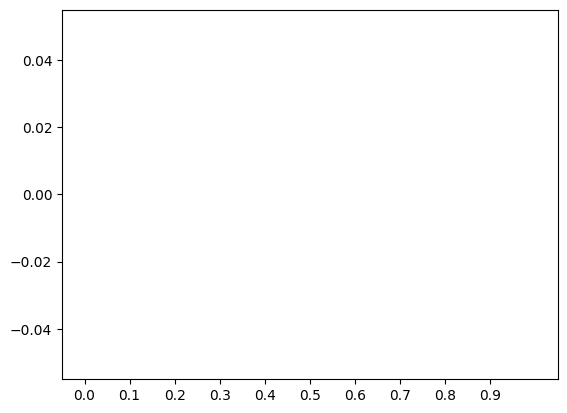

In [671]:
import matplotlib.pyplot as plt
#plt.plot(np.arange(len(cycle_time_store)),cycle_time_store)
plt.hist(cycle_time_store,bins=50)
plt.xticks(np.arange(0,1,0.1))
print(np.mean(cycle_time_store))
print(len(cycle_time_store))

In [672]:
stochastic_cost_function((0, -2, -2, 1))

468.8783955226833

In [673]:
ISC(total_budget,alpha,no_of_clusters)

total budget:  300000.0
no of clusters:  2
clusters: dict_keys([(10, -9, -5, 7)])
GA Budget over
fitness:  [1.0]
i= 0
step_size:  5
step_size:  5
sampling time:  1.3828277587890625e-05
global time:  1.4066696166992188e-05
heaping time:  3.0994415283203125e-06
grobi time:  0.8644380569458008
V_k post prunning:  [[10, -9, -5, 7], [27, -24, -4, 30], [23, -24, -9, 33], [22, -28, -1, 37], [23, -27, -11, 32], [19, -26, -8, 29], [17, -27, -7, 34], [16, -30, -6, 31], [19, -22, -8, 33], [19, -27, -8, 27], [13, -30, -6, 37], [16, -26, -12, 28], [23, -24, -7, 25], [29, -36, -10, 32], [17, -25, -17, 31], [18, -33, -2, 29], [21, -23, -6, 25], [19, -22, -6, 28], [16, -27, -6, 32], [23, -27, -5, 28], [22, -31, -1, 36], [20, -25, -4, 25], [25, -21, -11, 29], [23, -32, -2, 28], [22, -19, -12, 24], [18, -28, 0, 28], [14, -28, 1, 29], [19, -25, -11, 36], [13, -29, -7, 31], [20, -25, -9, 35], [28, -22, -5, 26]]
step_size:  5
vk and mp time:  0.0008392333984375
Cycle time:  1725812886.6053681
sampling time

([0, 0, 0, 0], 1.303507793400652)

In [674]:
'''clustering_outcomes = []
import gc
import matplotlib.pyplot as plt

# Iterate over ratio_ga_compass and cluster_count values
for ratio in np.arange(0.6, 0.9, 0.1):  # Include 1.0 in the range
    for clusters in range(3, 6):  # cluster_count values from 1 to 5
        print(f'ratio_ga_compass = {ratio:.1f}, cluster_count = {clusters}')
        
        # Run improved_stochastic_clustering 4 times and keep the minimum
        best_value = float('inf')
        best_configuration = None
        for _ in range(4):
            print(_)
            configuration, performance = ISC(total_budget, ratio, clusters)
            if performance < best_value:
                best_value = performance
                best_configuration = configuration
        print('-'*20)
        clustering_outcomes.append((ratio, clusters, best_value))
        print(f'Best performance after 4 runs: {best_value}')
        # Define the variables you want to keep
        
# Convert clustering_outcomes to a numpy array for easier manipulation
outcome_array = np.array(clustering_outcomes)

# Create a plot for each ratio value
for ratio in np.unique(outcome_array[:, 0]):
    plt.figure(figsize=(10, 6))
    ratio_data = outcome_array[outcome_array[:, 0] == ratio]
    plt.plot(ratio_data[:, 1], ratio_data[:, 2], marker='o')
    
    plt.title(f'Best Performance for Ratio={ratio:.1f} (4 runs each)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Best Performance Value')
    plt.grid(True)
    #plt.savefig(f'performance_ratio_{ratio:.1f}.png')
    plt.close()

# Create a single plot with all ratio values
plt.figure(figsize=(12, 8))
for ratio in np.unique(outcome_array[:, 0]):
    ratio_data = outcome_array[outcome_array[:, 0] == ratio]
    plt.plot(ratio_data[:, 1], ratio_data[:, 2], marker='o', label=f'Ratio={ratio:.1f}')

plt.title('Best Performance for Different Ratios and Cluster Counts (4 runs each)')
plt.xlabel('Number of Clusters')
plt.ylabel('Best Performance Value')
plt.legend()
plt.grid(True)'''

"clustering_outcomes = []\nimport gc\nimport matplotlib.pyplot as plt\n\n# Iterate over ratio_ga_compass and cluster_count values\nfor ratio in np.arange(0.6, 0.9, 0.1):  # Include 1.0 in the range\n    for clusters in range(3, 6):  # cluster_count values from 1 to 5\n        print(f'ratio_ga_compass = {ratio:.1f}, cluster_count = {clusters}')\n        \n        # Run improved_stochastic_clustering 4 times and keep the minimum\n        best_value = float('inf')\n        best_configuration = None\n        for _ in range(4):\n            print(_)\n            configuration, performance = ISC(total_budget, ratio, clusters)\n            if performance < best_value:\n                best_value = performance\n                best_configuration = configuration\n        print('-'*20)\n        clustering_outcomes.append((ratio, clusters, best_value))\n        print(f'Best performance after 4 runs: {best_value}')\n        # Define the variables you want to keep\n        \n# Convert clustering_ou

In [675]:
get_n_neighbours([100,100,100,100],6)

step_size:  1


[[100, 100, 100, 100],
 [98, 100, 99, 98],
 [100, 99, 100, 99],
 [100, 100, 100, 100],
 [98, 100, 99, 99],
 [99, 100, 100, 99]]